<a href="https://colab.research.google.com/github/MauricioMatheus/Data_Structures_2_Final_Project/blob/main/Final_Project_pt_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


In [73]:
nodes_file = "GraphTest_nodes.txt"
edges_file = "GraphTest_edges.txt"

df_nodes = pd.read_csv(nodes_file, sep="\t")
df_edges = pd.read_csv(edges_file, sep="\t")

# Preview the node data
print("Nodes:")
display(df_nodes.head())  # Shows the first few rows of the node DataFrame

# Preview the edge data
print("Edges:")
display(df_edges.head())  # Shows the first few rows of the edge DataFrame

Nodes:


,NodeId,Chain,Position,Residue,Type,Dp,Degree,factor_CA,x,y,z,FileName,Model
0,A:1:_:V,A,1,V,RES,,1,33.95,29.327,7.238,10.067,source_file,1
1,A:2:_:H,A,2,H,RES,,2,42.00,31.580,6.093,7.224,source_file,1
2,A:3:_:L,A,3,L,RES,,0,37.65,31.355,7.827,3.837,source_file,1
3,A:4:_:T,A,4,T,RES,,4,51.65,33.572,7.162,0.748,source_file,1
4,A:5:_:P,A,5,P,RES,H,1,55.92,35.236,9.897,-1.408,source_file,1


Edges:


,NodeId1,Interaction,NodeId2,Distance,Angle,Node1,Node2,Donor,Positive,Ct,Orientation,Model
0,A:1:_:V,V:SC_SC,A:81:_:L,2.897,NaN,CG2,HD11,NaN,NaN,NaN,NaN,1
1,A:2:_:H,H:MC_MC,B:146:_:H,3.247,161.843,N,O,A:2:_:H,NaN,NaN,NaN,1
2,A:2:_:H,V:SC_SC,B:146:_:H,2.377,NaN,H,HXT,NaN,NaN,NaN,NaN,1
3,A:4:_:T,H:SC_SC,A:7:_:E,2.490,138.501,OG1,OE1,A:4:_:T,NaN,NaN,NaN,1
4,A:4:_:T,H:MC_SC,A:7:_:E,2.556,168.517,N,OE1,A:4:_:T,NaN,NaN,NaN,1


In [74]:
# Initialize as a MultiDiGraph to support multiple directed edges between the same pair of nodes
# G = nx.MultiDiGraph()

# Use MultiGraph() instead of MultiDiGraph() if directionality is not important.
# This allows multiple undirected edges between the same node pairs, useful for modeling
# symmetric or bidirectional interactions like Van der Waals forces.
G = nx.MultiGraph()

# Add all nodes with their attributes
for _, row in df_nodes.iterrows():
    node_id = row["NodeId"]                      # Extract the node identifier
    attributes = row.drop("NodeId").to_dict()    # Convert the remaining columns to a dictionary of attributes
    G.add_node(node_id, **attributes)            # Add the node and its attributes to the graph

print(f"Graph created with {G.number_of_nodes()} nodes.")


Graph created with 588 nodes.


In [75]:
# Accessing the attributes of a specific node in the graph
# Each node represents an abstract element with several associated properties.
# These attributes may include:
# - Position: the element's index or sequence number
# - Type: classification or category of the element
# - Degree: number of connections this node has in the graph
# - Numerical values (e.g., factor_CA): possibly representing some measurement or score
# - Coordinates (x, y, z): spatial or geometric positioning
# - Metadata: such as source file name or model identifier

G.nodes["A:1:_:V"]

{'Chain': 'A',
 'Position': 1,
 'Residue': 'V',
 'Type': 'RES',
 'Dp': ' ',
 'Degree': 1,
 'factor_CA': 33.95,
 'x': 29.327,
 'y': 7.238,
 'z': 10.067,
 'FileName': 'source_file',
 'Model': 1}

In [76]:
# Adds all columns as edge attributes, allowing multiple edges between the same pair of nodes
for _, row in df_edges.iterrows():
    source = row["NodeId1"]                  # Source node identifier
    target = row["NodeId2"]                  # Target node identifier
    attributes = row.drop(["NodeId1", "NodeId2"]).to_dict()  # All remaining columns become edge attributes

    # Safe conversion of numeric values (e.g., distance, angle, etc.)
    for key in attributes:
        val = attributes[key]
        if pd.isna(val) or val == "nan":     # Handle missing or non-numeric values
            attributes[key] = None
        else:
            try:
                attributes[key] = float(val)  # Convert strings to float when possible
            except (ValueError, TypeError):
                pass  # Leave as string if conversion fails

    # Add the edge with its full set of attributes
    # Since we are using MultiDiGraph, multiple edges between the same nodes are allowed and preserved
    G.add_edge(source, target, **attributes)

print(f"Graph created with {G.number_of_edges()} edges (multiple interactions per node pair allowed).")

Graph created with 1184 edges (multiple interactions per node pair allowed).


In [77]:
# Accessing the attributes of a specific edge in a MultiDiGraph
# Since multiple edges are allowed between the same pair of nodes, we use a 3-element key:
# (source_node, target_node, edge_index)
# This retrieves the edge with index 0 between nodes "A:1:_:V" and "A:81:_:L"

G.edges[('A:1:_:V', 'A:81:_:L', 0)]

# The returned dictionary contains all the metadata associated with this specific interaction:
# - Interaction: a label describing the type of interaction or connection
# - Distance: a numeric value that may represent spatial proximity or intensity
# - Angle: geometric property, if applicable
# - Node1 / Node2: identifiers for specific components involved in the interaction
# - Donor, Positive, Ct, Orientation: optional descriptors that may or may not be filled
# - Model: model or version identifier, useful in some datasets

{'Interaction': 'V:SC_SC',
 'Distance': 2.897,
 'Angle': None,
 'Node1': 'CG2',
 'Node2': 'HD11',
 'Donor': None,
 'Positive': None,
 'Ct': None,
 'Orientation': None,
 'Model': 1.0}

In [78]:
print("Convertendo o Multigrafo para um Grafo simples para o cálculo do k-core...")
G_simple = nx.Graph(G)

print("Calculando a decomposição k-core no grafo simplificado...")
core_numbers = nx.core_number(G_simple)

nx.set_node_attributes(G, core_numbers, 'kcore')

print("Atributo 'kcore' adicionado com sucesso a todos os nós do grafo original.")


Convertendo o Multigrafo para um Grafo simples para o cálculo do k-core...
Calculando a decomposição k-core no grafo simplificado...
Atributo 'kcore' adicionado com sucesso a todos os nós do grafo original.


In [79]:
# Example: list all edges from node A:4:_:T to node A:7:_:E
source = "A:4:_:T"
target = "A:7:_:E"

# Retrieves a dictionary containing all edges between the two nodes,
# where each entry is indexed by a unique edge key (usually an integer starting from 0)
multi_edges = G.get_edge_data(source, target)

# Print all individual interactions (edges) between these two nodes
for key, attrs in multi_edges.items():
    print(f"Edge {key}:")  # Each key represents a unique edge ID between the same source and target
    for attr, value in attrs.items():
        print(f"  {attr}: {value}")  # Print each attribute of the edge
    print()

Edge 0:
  Interaction: H:SC_SC
  Distance: 2.49
  Angle: 138.501
  Node1: OG1
  Node2: OE1
  Donor: A:4:_:T
  Positive: None
  Ct: None
  Orientation: None
  Model: 1.0

Edge 1:
  Interaction: H:MC_SC
  Distance: 2.556
  Angle: 168.517
  Node1: N
  Node2: OE1
  Donor: A:4:_:T
  Positive: None
  Ct: None
  Orientation: None
  Model: 1.0

Edge 2:
  Interaction: V:SC_SC
  Distance: 2.729
  Angle: None
  Node1: OG1
  Node2: HG3
  Donor: None
  Positive: None
  Ct: None
  Orientation: None
  Model: 1.0



In [80]:
def sanitize_attributes(G):
    # Fix node attributes: replace None or NaN values with empty strings
    for node, attrs in G.nodes(data=True):
        for k, v in attrs.items():
            if v is None or (isinstance(v, float) and pd.isna(v)):
                G.nodes[node][k] = ""

    # Fix edge attributes: replace None or NaN values with empty strings
    for u, v, key, attrs in G.edges(keys=True, data=True):
        for k, v_attr in attrs.items():
            if v_attr is None or (isinstance(v_attr, float) and pd.isna(v_attr)):
                G.edges[u, v, key][k] = ""

# Apply attribute sanitization to make the graph exportable to GEXF format
sanitize_attributes(G)

# Export the graph to a GEXF file, which can be opened in Gephi or reloaded in Python
nx.write_gexf(G, "final_netwokr.gexf")
print("Export completed successfully.")

Export completed successfully.


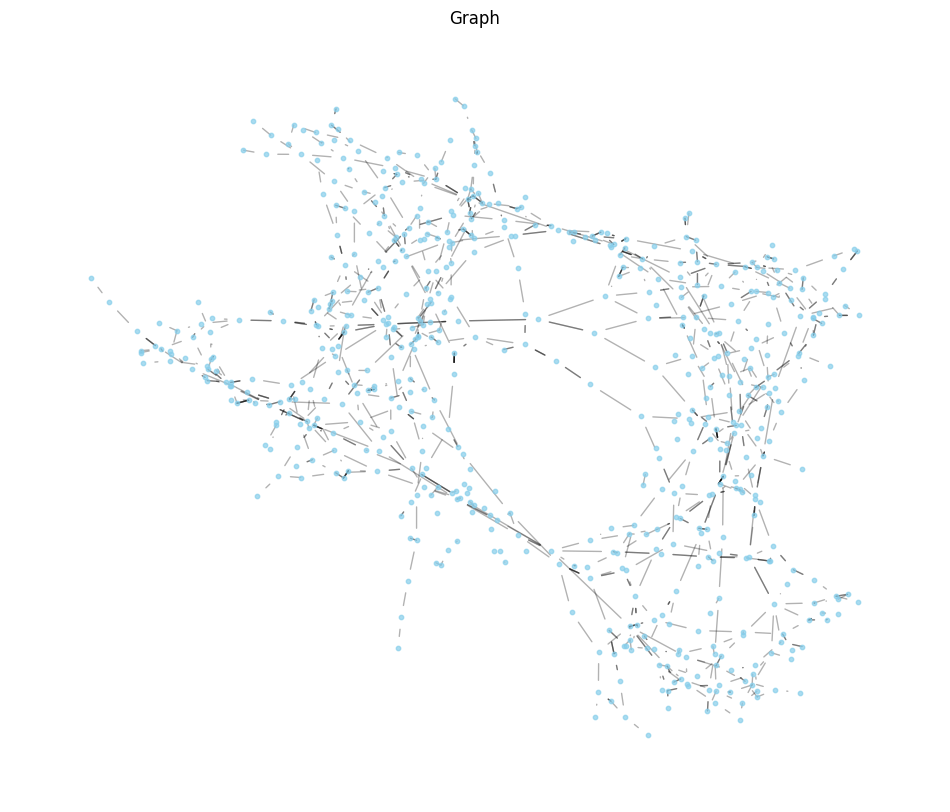

In [81]:
# Generate a layout for positioning the nodes using a force-directed algorithm
# 'seed' ensures the layout is reproducible
pos = nx.spring_layout(G, seed=42)

# Set up the figure size
plt.figure(figsize=(12, 10))

# Draw the graph nodes with small size and light color
nx.draw_networkx_nodes(G, pos, node_size=10, node_color='skyblue', alpha=0.7)

# Draw the edges with some transparency
nx.draw_networkx_edges(G, pos, alpha=0.3)

# Set the plot title and remove axes
plt.title("Graph")
plt.axis('off')

# Display the final visualization
plt.show()
